# Activeloop DeepLake's DeepMemory + LangChain + ragas or how to get +27% on RAG recall.

Retrieval-Augmented Generators (RAGs) have recently gained significant attention. As advanced RAG techniques and agents emerge, they expand the potential of what RAGs can accomplish. However, several challenges may limit the integration of RAGs into production. The primary factors to consider when implementing RAGs in production settings are accuracy (recall), cost, and latency. For basic use cases, OpenAI's Ada model paired with a naive similarity search can produce satisfactory results. Yet, for higher accuracy or recall during searches, one might need to employ advanced retrieval techniques. These methods might involve varying data chunk sizes, rewriting queries multiple times, and more, potentially increasing latency and costs.  [Activeloop's](https://activeloop.ai/) [Deep Memory](https://www.activeloop.ai/resources/use-deep-memory-to-boost-rag-apps-accuracy-by-up-to-22/) a feature available to Activeloop Deep Lake users, addresses these issuea by introducing a tiny neural network layer trained to match user queries with relevant data from a corpus. While this addition incurs minimal latency during search, it can boost retrieval accuracy by up to 27
% and remains cost-effective and simple to use, without requiring any additional advanced rag techniques.


For this tutorial we will parse deeplake documentation, and create a RAG system that could answer the question from the docs. 

The tutorial can be divided into several parts:
1. [Dataset creation and uploading](#1-dataset-creation)
2. [Generating synthetic queries and training deep_memory](#2-generating-synthetic-queries-and-training-deep_memory)
3. [Evaluating deep memory performance](#3-evaluating-deep-memory-performance)
    - 3.1 [using deepmemory recall@10 metric](#31-using-deepmemory-recall10-metric)
    - 3.2 [using ragas](#32-deepmemory--ragas)
    - 3.3 [deep_memory inference](#33-deepmemory-inference)
    - 3.4 [deep_memory cost savings](#34-cost-savings)

<a name="dataset-creation"></a>
## 1. Dataset Creation

We will parse activeloop's docs for this tutorial using `BeautifulSoup` library and LangChain's document parsers like `Html2TextTransformer`, `AsyncHtmlLoader`. So we will need to install the following libraries:

In [ ]:
!pip install tiktoken openai python-dotenv datasets langchain deeplake beautifulsoup4 html2text ragas

Also you'll need to create a [Activeloop]((https://activeloop.ai/)) account.

In [ ]:
import os
import getpass

from langchain.vectorstores.deeplake import DeepLake

from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chains import RetrievalQA
from langchain.llms import OpenAIChat


os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API token: ")
# # activeloop token is needed if you are not signed in using CLI: `activeloop login -u <USERNAME> -p <PASSWORD>`
os.environ["ACTIVELOOP_TOKEN"] = getpass.getpass(
    "Enter your ActiveLoop API token: "
)  # Get your API token from https://app.activeloop.ai, click on your profile picture in the top right corner, and select "API Tokens"

token = os.getenv("ACTIVELOOP_TOKEN")
openai_embeddings = OpenAIEmbeddings()

In [ ]:
db = DeepLake(
    dataset_path=f"hub://{ORG_ID}/deeplake-docs-deepmemory",  # org_id stands for your username or organization from activeloop
    embedding=openai_embeddings,
    runtime={"tensor_db": True},
    token=token,
    # overwrite=True, # user overwrite flag if you want to overwrite the full dataset
    read_only=False,
)

parsing all links in the webpage using `BeautifulSoup`

In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin


def get_all_links(url):
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve the page: {url}")
        return []

    soup = BeautifulSoup(response.content, "html.parser")

    # Finding all 'a' tags which typically contain href attribute for links
    links = [
        urljoin(url, a["href"]) for a in soup.find_all("a", href=True) if a["href"]
    ]

    return links


base_url = "https://docs.deeplake.ai/en/latest/"
all_links = get_all_links(base_url)

Loading data:

In [ ]:
from langchain.document_loaders import AsyncHtmlLoader

loader = AsyncHtmlLoader(all_links)
docs = loader.load()

Converting data into user readable format:

In [ ]:
from langchain.document_transformers import Html2TextTransformer

html2text = Html2TextTransformer()
docs_transformed = html2text.transform_documents(docs)

Now, let us chunk further the documents as some of the contain too much text:

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter


chunk_size = 4096
docs_new = []

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
)

for doc in docs_transformed:
    if len(doc.page_content) < chunk_size:
        docs_new.append(doc)
    else:
        docs = text_splitter.create_documents([doc.page_content])
        docs_new.extend(docs)

Populating VectorStore:

In [ ]:
docs = db.add_documents(docs_new)

<a name="training"></a>
## 2. Generating synthetic queries and training deep_memory 

Next step would be to train a deep_memory model that will align your users queries with the dataset that you already have. If you don't have any user queries yet, no worries, we will generate them using LLM!

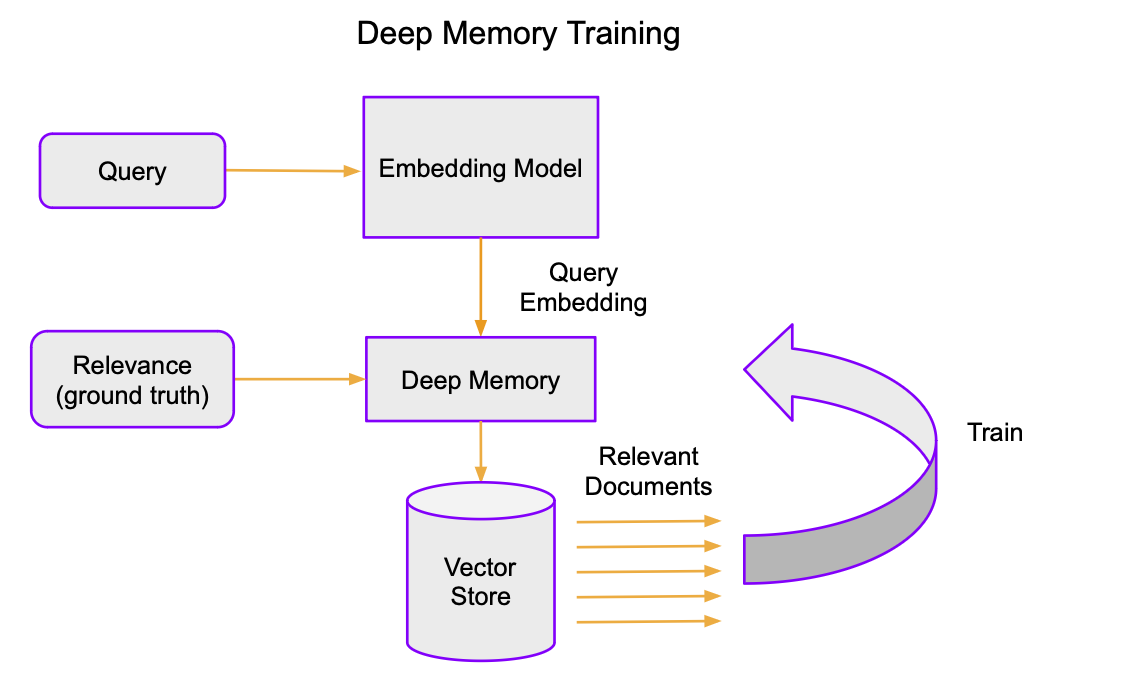

Here above we showed the overall schema how deep_memory works. So as you can see, in order to train it you need relevence, queries together with corpus data (data that we want to query). Corpus data was already populated in the previous section, here we will be generating questions and relevance. 

1. `questions` - is a text of strings, where each string represents a query
2. `relevence` - contains links to the ground truth for each question. There might be several docs that contain answer to the given question. Because of this relevenve is `List[List[tuple[str, float]]]`, where outer list represents queries and inner list relevent documents. Tuple contains str, float pair where string represent the id of the source doc (corresponds to the `id` tensor in the dataset), while float corresponds to how much current document is related to the question.  

Now, let us generate synthetic questions and relevance:

In [ ]:
from typing import Optional, List

from langchain.chains.openai_functions import (
    create_openai_fn_chain,
    create_structured_output_chain,
)
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain.schema import HumanMessage, SystemMessage

from pydantic import BaseModel, Field

In [ ]:
# fetch dataset docs and ids if they exist (optional you can also ingest)
docs = db.vectorstore.dataset.text.data(fetch_chunks=True, aslist=True)["value"]
ids = db.vectorstore.dataset.id.data(fetch_chunks=True, aslist=True)["value"]

In [ ]:
# If we pass in a model explicitly, we need to make sure it supports the OpenAI function-calling API.
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)


class Questions(BaseModel):
    """Identifying information about a person."""

    question: str = Field(..., description="Questions about text")


prompt_msgs = [
    SystemMessage(
        content="You are a world class expert for generating questions based on provided context. \
                You make sure the question can be answered by the text."
    ),
    HumanMessagePromptTemplate.from_template(
        "Use the given text to generate a question from the following input: {input}"
    ),
    HumanMessage(content="Tips: Make sure to answer in the correct format"),
]
prompt = ChatPromptTemplate(messages=prompt_msgs)
chain = create_structured_output_chain(Questions, llm, prompt, verbose=True)

text = "# Understanding Hallucinations and Bias ## **Introduction** In this lesson, we'll cover the concept of **hallucinations** in LLMs, highlighting their influence on AI applications and demonstrating how to mitigate them using techniques like the retriever's architectures. We'll also explore **bias** within LLMs with examples."
questions = chain.run(input=text)
print(questions)

In [ ]:
import random
from tqdm import tqdm
from langchain.embeddings import OpenAIEmbeddings


def generate_queries(docs: List[str], ids: List[str], n: int = 100):
    questions = []
    relevances = []
    pbar = tqdm(total=n)
    while len(questions) < n:
        # 1. randomly draw a piece of text and relevance id
        r = random.randint(0, len(docs) - 1)
        text, label = docs[r], ids[r]

        # 2. generate queries and assign and relevance id
        generated_qs = [chain.run(input=text).question]
        questions.extend(generated_qs)
        relevances.extend([[(label, 1)] for _ in generated_qs])
        pbar.update(len(generated_qs))
        if len(questions) % 10 == 0:
            print(f"q: {len(questions)}")
    return questions[:n], relevances[:n]


chain = create_structured_output_chain(Questions, llm, prompt, verbose=False)
questions, relevances = generate_queries(docs, ids, n=200)

train_questions, train_relevances = questions[:100], relevances[:100]
test_questions, test_relevances = questions[100:], relevances[100:]

Now we created 100 training queries as well as 100 queries for testing. Now let us train the deep_memory:

In [ ]:
job_id = db.vectorstore.deep_memory.train(
    queries=train_questions,
    relevance=train_relevances,
)

Let us track the training progress:

In [1]:
db.vectorstore.deep_memory.status("6538939ca0b69a9ca45c528c")


--------------------------------------------------------------
|                  6538e02ecda4691033a51c5b                  |
--------------------------------------------------------------
| status                     | completed                     |
--------------------------------------------------------------
| progress                   | eta: 1.4 seconds              |
|                            | recall@10: 79.00% (+34.00%)   |
--------------------------------------------------------------
| results                    | recall@10: 79.00% (+34.00%)   |
--------------------------------------------------------------



<a name="evaluation"></a>
## 3. Evaluating deep memory performance

Great we've trained the model! It's showing some substantial improvement in recall, but how can we use it now and evaluate on unseen new data? In this section we will delve into model evaluation and inference part and see how it can be used with LangChain in order to increase retrieval accuracy

<a name="recall@10"></a>
### 3.1 using deepmemory recall@10 metric

For the beginning we can use deep_memory's builtin evaluation method. it can be done easily in a few lines of code:

In [2]:
recall = db.vectorstore.deep_memory.evaluate(
    queries=test_questions,
    relevance=test_relevances,
)


Embedding queries took 0.81 seconds
---- Evaluating without model ---- 
Recall@1:	  9.0%
Recall@3:	  19.0%
Recall@5:	  24.0%
Recall@10:	  42.0%
Recall@50:	  93.0%
Recall@100:	  98.0%
---- Evaluating with model ---- 
Recall@1:	  19.0%
Recall@3:	  42.0%
Recall@5:	  49.0%
Recall@10:	  69.0%
Recall@50:	  97.0%
Recall@100:	  97.0%



It is showing quite substatntial improvement on an unseen test dataset too!!!

<a name="ragas"></a>
### 3.2 DeepMemory + ragas

In [ ]:
from ragas.metrics import (
    context_recall,
)
from ragas.langchain import RagasEvaluatorChain

Let us convert recall into ground truths:

In [ ]:
def convert_relevance_to_ground_truth(docs, relevance):
    ground_truths = []

    for rel in relevance:
        ground_truth = []
        for doc_id, _ in rel:
            ground_truth.append(docs[doc_id])
        ground_truths.append(ground_truth)
    return ground_truths

In [3]:
ground_truths = convert_relevance_to_ground_truth(docs, test_relevances)

for deep_memory in [False, True]:
    print("\nEvaluating with deep_memory =", deep_memory)
    print("===================================")

    retriever = db.as_retriever()
    retriever.search_kwargs["deep_memory"] = deep_memory

    qa_chain = RetrievalQA.from_chain_type(
        llm=OpenAIChat(model="gpt-3.5-turbo"),
        chain_type="stuff",
        retriever=retriever,
        return_source_documents=True,
    )

    metrics = {
        "context_recall_score": 0,
    }

    eval_chains = {m.name: RagasEvaluatorChain(metric=m) for m in [context_recall]}

    for question, ground_truth in zip(test_questions, ground_truths):
        result = qa_chain({"query": question})
        result["ground_truths"] = ground_truth
        for name, eval_chain in eval_chains.items():
            score_name = f"{name}_score"
            metrics[score_name] += eval_chain(result)[score_name]

    for metric in metrics:
        metrics[metric] /= len(test_questions)
        print(f"{metric}: {metrics[metric]}")
    print("===================================")


Evaluating with deep_memory = False
context_recall_score = 0.3763423145

Evaluating with deep_memory = True
context_recall_score = 0.5634545323



<a name="inference"></a>
### 3.3 DeepMemory Inference

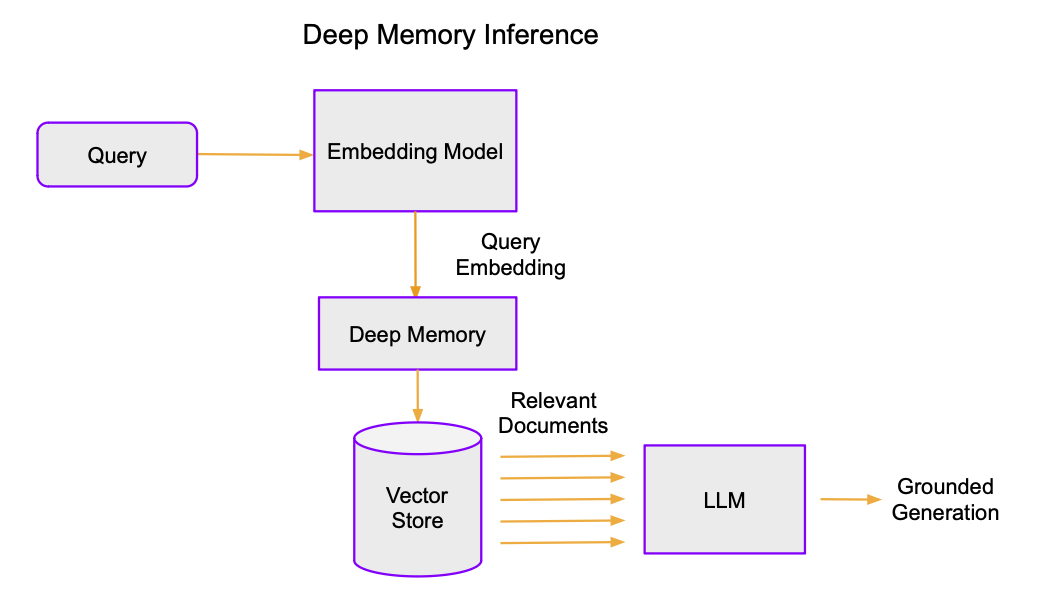

with deep_memory

In [4]:
retriver = db.as_retriever()
retriver.search_kwargs["deep_memory"] = True
retriver.search_kwargs["k"] = 10

query = "Deamination of cytidine to uridine on the minus strand of viral DNA results in catastrophic G-to-A mutations in the viral genome."
qa = RetrievalQA.from_chain_type(
    llm=OpenAIChat(model="gpt-4"), chain_type="stuff", retriever=retriver
)
print(qa.run(query))

The base htype of the 'video_seq' tensor is 'video'.


without deep_memory

In [5]:
retriver = db.as_retriever()
retriver.search_kwargs["deep_memory"] = False
retriver.search_kwargs["k"] = 10

query = "Deamination of cytidine to uridine on the minus strand of viral DNA results in catastrophic G-to-A mutations in the viral genome."
qa = RetrievalQA.from_chain_type(
    llm=OpenAIChat(model="gpt-4"), chain_type="stuff", retriever=retriver
)
qa.run(query)

The text does not provide information on the base htype of the 'video_seq' tensor.


<a name="cost"></a>
### 3.4 Cost savings

Deep Memory increases retrieval accuracy without altering your existing workflow. Additionally, by reducing the top_k input into the LLM, you can significantly cut inference costs via lower token usage.